## 1.  Connect google Drive.


In [19]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 2. Import Libraries.

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential #Initialise our neural network model as a sequential network
from keras.layers import Conv2D #Convolution operation
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.layers import Activation#Applies activation function
from keras.layers import Dropout#Prevents overfitting by randomly converting few outputs to zero
from keras.layers import MaxPooling2D # Maxpooling function
from keras.layers import Flatten # Converting 2D arrays into a 1D linear vector
from keras.layers import Dense # Regular fully connected neural network
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import accuracy_score

from keras import backend


## 3. Define Data loading mechanism.
     


In [21]:
def load_data(dataset_path):
  
  #classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprsie', 'Neutral']  #We will be dealing with seven different types of emotions.

  data = []
  test_data = []
  test_labels = []
  labels =[]

  with open(dataset_path, 'r') as file:
      for line_no, line in enumerate(file.readlines()):
          if 0 < line_no <= 35887:
            curr_class, line, set_type = line.split(',')
            image_data = np.asarray([int(x) for x in line.split()]).reshape(48, 48)#Creating a list out of the string then converting it into a 2-Dimensional numpy array.
            image_data =image_data.astype(np.uint8)/255.0
            
            if (set_type.strip() == 'PrivateTest'):
              
              test_data.append(image_data)
              test_labels.append(curr_class)
            else:
              data.append(image_data)
              labels.append(curr_class)
      
      test_data = np.expand_dims(test_data, -1)
      test_labels = to_categorical(test_labels, num_classes = 7)
      data = np.expand_dims(data, -1)   
      labels = to_categorical(labels, num_classes = 7)
    
      return np.array(data), np.array(labels), np.array(test_data), np.array(test_labels)

## 4. Load the data.


In [35]:
dataset_path = "/content/gdrive/My Drive/Colab Notebooks/fer2013.csv" 
train_data, train_labels, test_data, test_labels = load_data(dataset_path)
#train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = test_size,random_state = seed)

#print(test_labels)
#print(test_data)
print("Number of images in Training set:", len(train_data))
print("Number of images in Test set:", len(test_data))

Number of images in Training set: 32298
Number of images in Test set: 3589


## 5. Define and Deploy the neural network.


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_40 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_41 (Batc (None, 23, 23, 128)      

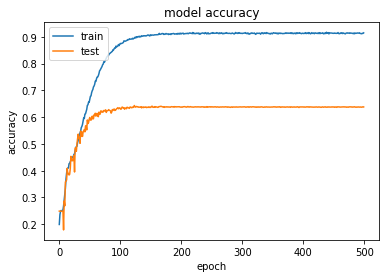

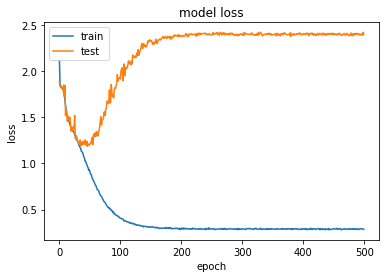

In [28]:
#######HYPERPARAMATERS###########
epochs = 500
batch_size = 64
learning_rate = 0.001
#################################

model = Sequential()
    
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1), kernel_regularizer=l2(0.01)))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))
adam = optimizers.Adam(lr = learning_rate)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
print(model.summary())

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3)
early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=500, mode='auto')
checkpointer = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Model500/weights.hd5', monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit(
          train_data,
          train_labels,
          epochs = epochs,
          batch_size = batch_size,
          validation_split = 0.2,
          shuffle = True,
          callbacks=[lr_reducer, checkpointer, early_stopper]
          )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 6. Test the model.

Accuracy score =  0.636667595430482


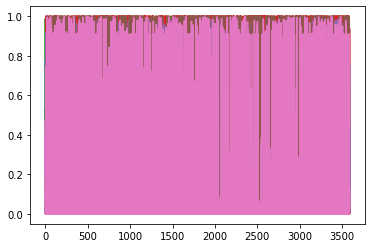

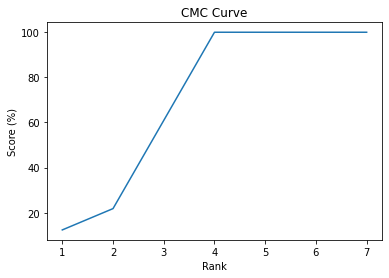

In [37]:
predicted_test_labels = np.argmax(model.predict(test_data), axis=1)
test_labels = np.argmax(test_labels, axis=1)
print ("Accuracy score = ", accuracy_score(test_labels, predicted_test_labels))
#print("PTL: ", model.predict(test_data))
#print("TL: ", test_labels)
plt.plot(model.predict(test_data))
plt.show()

y_pred = model.predict(test_data)
y_test = test_labels
ranks = 7

def calculate_cmc(y_pred, y_test, num_ranks=10):

    ranks = num_ranks
    rank_scores = np.zeros(ranks)

    for el_pred, el_true in zip(y_pred, y_test):   
        for r in range(ranks):
            r_max_val_ind = np.argsort(el_pred)[-(r+1):][0]
            r_max_val = el_pred[r_max_val_ind]
            correct_ranks = ((el_pred >= r_max_val) * 1)

            yind = np.argmax(el_true, axis=-1)
            if correct_ranks[yind] == 1:
                rank_scores[r] += 1


    rank_scores = rank_scores / y_pred.shape[0]
    return rank_scores

scores = calculate_cmc(y_pred, y_test, num_ranks=ranks)

plt.plot(np.arange(1,ranks+1), scores*100)
plt.title("CMC Curve")
plt.xlabel("Rank")
plt.xticks(np.arange(1,ranks+1))
plt.ylabel("Score (%)")
plt.show()


## 7. Save the model.

In [36]:
from keras.models import model_from_json
model_json = model.to_json()
with open("/content/gdrive/My Drive/Colab Notebooks/Model500/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/gdrive/My Drive/Colab Notebooks/Model500/model.h5")
print("Saved model to disk")

Saved model to disk
